In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect the columns for both tables
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

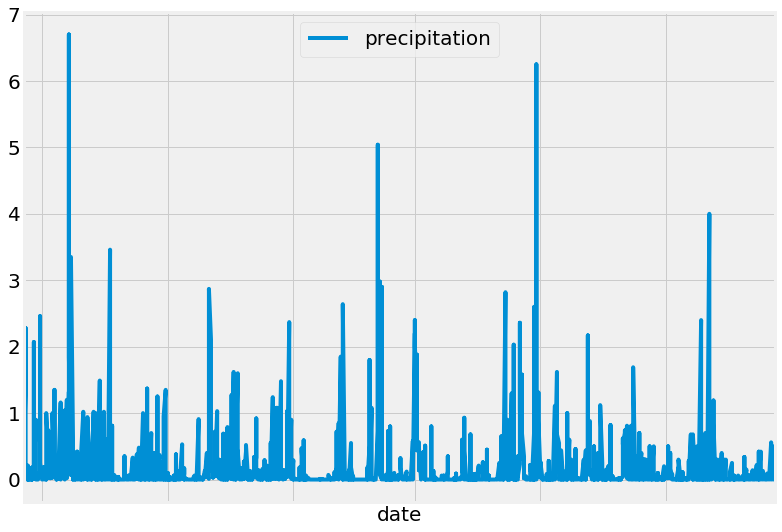

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).all()
precip
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip).dropna().set_index('date')
precip_df.index = pd.to_datetime(precip_df.index)

# Calculate the date 1 year ago from the last data point in the database
mask = (precip_df.index >= '2016-08-23')
lastyear_precip =  precip_df.loc[mask]
lastyear_precip = lastyear_precip.rename(columns={'prcp': 'precipitation'})
lastyear_precip

# # Use Pandas Plotting with Matplotlib to plot the data
lastyear_precip.plot(figsize=(12,10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(loc='upper center', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("precipitation_time_series.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
lastyear_precip.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_frq = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_frq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_aggr = session.query(func.min(Measurement.tobs).label('min'),
    func.max(Measurement.tobs).label('max'),
    func.avg(Measurement.tobs).label('avg')
    ).\
    filter(Measurement.station == station_frq[0][0]).all()
tobs_aggr

[(54.0, 85.0, 71.66378066378067)]

In [17]:
## Check for missing values in the tobs column
# from sqlalchemy import case
# check = session.query(func.sum(case([(Measurement.tobs == True, 1)], else_=0).label('missing_values'))).all()
# check

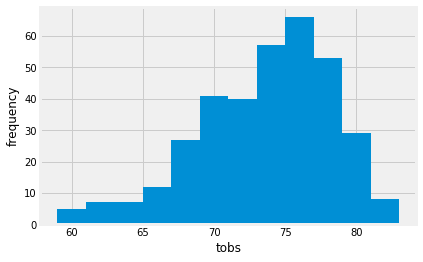

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_frq_station = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= '2016-08-23', Measurement.station == station_frq[0][0]).all()
tobs_frq_station_df = pd.DataFrame(tobs_frq_station)
hist_tobs = tobs_frq_station_df['tobs'].hist(bins=12, label='frequency')
plt.xlabel('tobs')
plt.ylabel("frequency")
plt.savefig("temp_frequency.png", bbox_inches='tight')
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_conditions = calc_temps("2016-08-23", "2017-08-23")[0]
trip_conditions

(58.0, 74.59058295964125, 87.0)

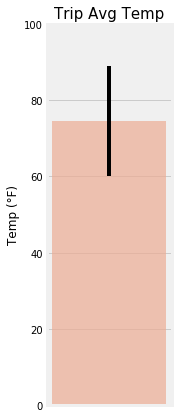

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,7))
plt.bar(x="", y=0, height=trip_conditions[1], 
        yerr=(trip_conditions[2]-trip_conditions[0])/2, 
        color='#ECAC94',
        alpha=0.7)
plt.ylabel('Temp (°F)')
plt.yticks(np.arange(0, 120, 20))
plt.title("Trip Avg Temp", fontsize=15)
plt.grid(False, axis='x')
plt.savefig("Trip_Avg_Temp.png", bbox_inches='tight')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_station = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp,).\
                    filter((Measurement.date > dt.date(2016,8,23)) | (Measurement.date < dt.date(2017,8,23))).\
                    filter(Measurement.station == Station.station).group_by(Measurement.station).\
                    order_by(Measurement.prcp.desc()).all()
prcp_station_df = pd.DataFrame(prcp_station, columns=['Station', 'Name', 'Latitude',\
                                                                     'Longitude', 'Elevation','Precipitation'])
# prcp_station_df.plot(stacked=False)
# prcp_station_df.head()
prcp_station_df

Station                                    Name  Latitude  Longitude  \
0  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
1  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920 -158.01110   
2  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
3  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
4  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
5  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
6  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520 -157.99920   
7  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
8  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   

   Elevation  Precipitation  
0       14.6           0.28  
1      306.6           0.21  
2       32.9           0.15  
3       19.5           0.15  
4      152.4           0.14  
5        3.0           0.08  
6        0.9           0.05  
7        7.0           0.01  
8       11.9            NaN

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]

## Optional Challenge Assignment

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[('2011-01-01', 62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(f"08-{i}")[0] for i in range(16,23)]
normals

[('2014-08-16', 69.0, 76.08, 83.0),
 ('2017-08-17', 69.0, 76.125, 83.0),
 ('2013-08-18', 70.0, 76.92307692307692, 84.0),
 ('2017-08-19', 69.0, 75.94642857142857, 85.0),
 ('2011-08-20', 68.0, 76.45283018867924, 82.0),
 ('2015-08-21', 67.0, 76.4, 83.0),
 ('2015-08-22', 69.0, 76.47169811320755, 84.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['Dates','Min','Avg','Max']).set_index('Dates')
normals_df.head()

Min        Avg   Max
Dates                            
2014-08-16  69.0  76.080000  83.0
2017-08-17  69.0  76.125000  83.0
2013-08-18  70.0  76.923077  84.0
2017-08-19  69.0  75.946429  85.0
2011-08-20  68.0  76.452830  82.0

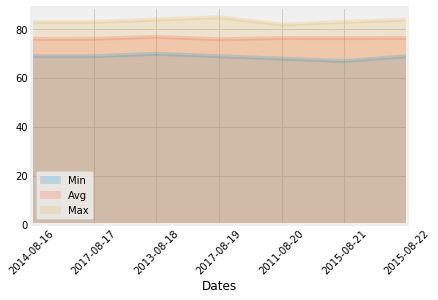

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False, alpha=.2)
plt.yticks(np.arange(0,100,20))
plt.xticks(rotation="45")
plt.show()

In [31]:
from flask import Flask, jsonify
app = Flask(__name__)

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all measurments"""
    # Query all passengers
    results = session.query(Measurement.date, Measurement.prcp).all()

    session.close()

    # Create a dictionary from the row data and append to a list of all_measurments
    all_measurements = []
    for date, prcp in results:
        measurement_dict = {}
        measurement_dict["date"] = date
        measurement_dict["precipitation"] = prcp
        all_measurements.append(measurement_dict)

    return jsonify(all_measurements)

@app.route("/api/v1.0/stations")
def stations():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all stations names"""
    # Query all passengers
    results = session.query(Station.station).all()

    session.close()
    
    #return statement
    
    all_stations = []
    for station in results:
        all_stations.append(station)
        
    return jsonify(all_stations)


@app.route("/api/v1.0/tobs")
def tobs():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    # Latest Date
    lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    lastDate = str(lastDate)
    lastDate = lastDate[2:]
    lastDate = lastDate[:-3]

    lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
    oneYearAgo = lastDate - dt.timedelta(days=365)
    
    lastYear = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= oneYearAgo).all()

    session.close()
    
    year_temps = []
    for date, temp in lastYear:
        temp_dict = {}
        temp_dict["date"] = date
        temp_dict["temperature"] = temp
        year_temps.append(temp_dict)
        
    return jsonify(year_temps)

@app.route("/api/v1.0/<start>")
def dateinfo(start):
    
    # Create our session (link) from Python to the DB
    session = Session(engine)
    
    # Start Date
    lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    lastDate = str(lastDate)
    lastDate = lastDate[2:]
    lastDate = lastDate[:-3]
    
    result = calc_temps_with_session(start, lastDate, session)
    
    return jsonify(result)

@app.route("/api/v1.0/<start>/<end>")
def datestartend(start, end):
    
    # Create our session (link) from Python to the DB
    session = Session(engine)

    result = calc_temps_with_session(start, end, session)
    
    return jsonify(result)
    
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Aug/2019 11:56:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Aug/2019 11:56:15] "GET /api/v1.0/precipitation HTTP/1.1" 200 -
127.0.0.1 - - [19/Aug/2019 12:02:38] "GET /api/v1.0/stations HTTP/1.1" 200 -
127.0.0.1 - - [19/Aug/2019 12:13:25] "GET /api/v1.0/tobs HTTP/1.1" 200 -
127.0.0.1 - - [19/Aug/2019 12:19:57] "GET /api/v1.0/01-04-2016 HTTP/1.1" 500 -
Traceback (most recent call last):
  File "C:\Users\bruno\Anaconda3\lib\site-packages\flask\app.py", line 2309, in __call__
    return self.wsgi_app(environ, start_response)
  File "C:\Users\bruno\Anaconda3\lib\site-packages\flask\app.py", line 2295, in wsgi_app
    response = self.handle_exception(e)
  File "C:\Users\bruno\Anaconda3\lib\site-packages\flask\app.py", line 1741, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\bruno\Anaconda3\lib\site-packages\flask\_compat.py", line 35, in reraise
    raise value
  File "C:\Users\bruno\Ana